### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely areare you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

For starters, let's define a simple MDP from this picture:
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Markov_Decision_Process.svg/800px-Markov_Decision_Process.svg.png' width=300px>
_img by MistWiz (Own work) [Public domain], via Wikimedia Commons_

In [171]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

print(transition_probs['s0']['a0']['s2'])

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

0.5


We can now use MDP just as any other gym environment:

In [172]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [173]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [174]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    #V= np.zeros(len(mdp.get_all_states())) # initialize 3x1 (states x 1) matrix of values (max Q)
    #Q = np.zeros((len(mdp.get_all_states()), 2)) # initialize 3x2 matrix of Q's (states by actions)
    
    q = 0 
    print(mdp.get_next_states(state,action))
    for state_prime in mdp.get_next_states(state, action): 
        #print(state_prime)
        p = mdp.get_transition_prob(state, action, state_prime)
        r = mdp.get_reward(state, action, state_prime)
        g = gamma * state_values[state_prime]
        
        q += (p*(r+g))
        
        #print(p,r,g,q)
        
    return q 
        
            
 
    


In [175]:
import numpy as np
test_Vs = {s : i for i, s in enumerate(mdp.get_all_states())}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.allclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}


Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [176]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as per formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state): return 0
    
    V = 0 
    maxs = []
    
    #for each next state
    #append the max values
    for action in mdp.get_possible_actions(state): 
        maxs.append(get_action_value(mdp, state_values, state, action, gamma))
    V = np.amax(maxs)
    
    return  V

In [177]:
test_Vs_vopy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 0.69)
assert test_Vs == test_Vs_vopy, "please do not change state_values in get_new_state_value"

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}


Finally, let's combine everything we wrote into a working value iteration algo.

In [178]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
min_difference = 0.001 # stop VI if new values are this close to old values (or closer)

# initialize V(s)
state_values = {s : 0 for s in mdp.get_all_states()}


for i in range(num_iter):
    
    # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}
    assert isinstance(new_state_values, dict)
    
    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   "%(i, diff), end="")
    print('   '.join("V(%s) = %.3f"%(s, v) for s,v in state_values.items()), end='\n\n')
    state_values = new_state_values
    
    if diff < min_difference:
        print("Terminated"); break

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1'

In [179]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032)  < 0.01
assert abs(state_values['s1'] - 11.169) < 0.01
assert abs(state_values['s2'] - 8.921)  < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [180]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None
    action_list = mdp.get_possible_actions(state)
    
    some_action_values = []
    for action in mdp.get_possible_actions(state):
        some_action_values.append(get_action_value(mdp, state_values, state, action, gamma))

    return action_list[np.argmax(some_action_values)]

In [181]:
print(get_optimal_action(mdp, state_values, 's0', gamma))

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
a1


In [182]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a0'

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}


In [183]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)
    
print("average reward: ", np.mean(rewards))

assert(0.85 < np.mean(rewards) < 1.0)

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2

{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1'

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1'

{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1'

{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0

{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, '

{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 

{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 

{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.7, 's1': 0.1, 's2': 0.2}
{'s1': 0.95, 's2': 0.05}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's2': 0.4}
{'s0': 0.5, 's2': 0.5}
{'s2': 1}
{'s0': 0.4, 's1': 0.6}
{'s0': 0.3, 's1': 0.3, 's

### Frozen lake

In [189]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [190]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        #new_state_values = {s: 10 for s in mdp.get_all_states()}

        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        
        state_values = new_state_values
        if diff < min_difference:
            print("Terminated"); break
            
    return state_values

In [191]:
state_values = value_iteration(mdp)

{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 1.00000   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 

In [195]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done: break


*FFF
FHFH
FFFH
HFFG

{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
down

SFFF
*HFH
FFFH
HFFG

{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
down

SFFF
FHFH
*FFH
HFFG

{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
right

SFFF
FHFH
F*FH
HFFG

{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
down

SFFF
FHFH
FFFH
H*FG

{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
right

SFFF
FHFH
FFFH
HF*G

{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            #print(a)
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()



after iteration 0
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 1.00000   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 

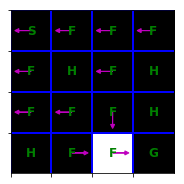

after iteration 1
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.90000   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 

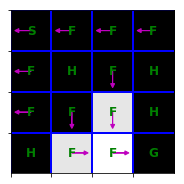

after iteration 2
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.81000   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 

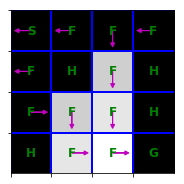

after iteration 3
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.72900   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 

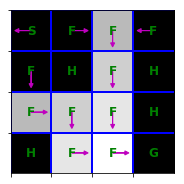

after iteration 4
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.65610   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 

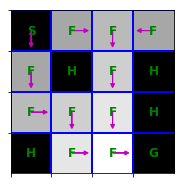

after iteration 5
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.59049   |   V(start): 0.590 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 

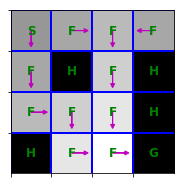

after iteration 6
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2):

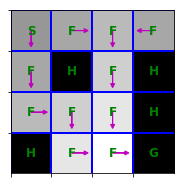

after iteration 7
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2):

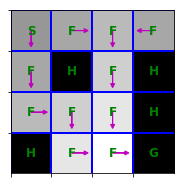

after iteration 8
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2):

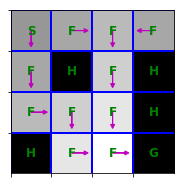

after iteration 9
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2):

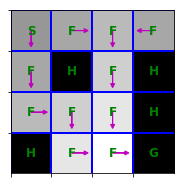

In [201]:
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 1): 0.05, (0, 0): 0.9, (1, 1): 0.05}
{(0, 0): 0.05, (1, 1): 0.9, (0, 2): 0.05}
{(1, 1): 0.05, (0, 2): 0.9, (0, 1): 0.05}
{(0, 2): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 2): 0.05, (0, 1): 0.9, (1, 2): 0.05}
{(0, 1): 0.05, (1, 2): 0.9, (0, 3): 0.05}
{(1, 2): 0.05, (0, 3): 0.9, (0, 2): 0.05}
{(0, 3): 0.05, (0, 2): 0.9, (0, 1): 0.05}
{(0, 3): 0.05, (0, 2): 0.9, (1, 3): 0.05}
{(0, 2): 0.05, (1, 3): 0.9, (0, 4): 0.05}
{(1, 3): 0.05, (0, 4): 0.9, (0, 3): 0.05}
{(0, 4): 0.05, (0, 3): 0.9, (0, 2): 0.05}
{(0, 4): 0.05, (0, 3): 0.9, (1, 4): 0.05}
{(0, 3): 0.05, (1, 4): 0.9, (0, 5): 0.05}
{(1, 4): 0.05, (0, 5): 0.9, (0, 4): 0.05}
{(0, 5): 0.05, (0, 4): 0.9, (0, 3): 0.05}
{(0, 5): 0.05, (0, 4): 0.9, (1, 5): 0.05}
{(0, 4): 0.05, (1, 5): 0.9, (0, 6): 0.05}
{(1, 5): 0.05, (0, 6): 0.9, (0, 5): 0.05}
{(0, 6): 0.05

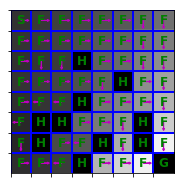

In [202]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [203]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(2, 1): 1.0}
{(3, 2): 1.0}
{(2, 3): 1.0}
{(1, 2): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
iter    0   |   diff: 1.00000   |   V(start): 0.000 
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(0, 2): 1.0}
{(0, 1): 1.0}
{(0, 1): 1.0}
{(1, 2): 1.0}
{(0, 3): 1.0}
{(0, 2): 1.0}
{(0, 2): 1.0}
{(1, 3): 1.0}
{(0, 3): 1.0}
{(0, 3): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(1, 1): 1.0}
{(2, 2): 1.0}
{(1, 3): 1.0}
{(0, 2): 

{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0

{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0

{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1

{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0

{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1

{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0

{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0

{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0

{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3): 1.0}
{(2, 2): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(0, 1): 1.0}
{(0, 0): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(1, 1): 1.0}
{(0, 0): 1.0}
{(2, 0): 1.0}
{(3, 0): 1.0}
{(2, 1): 1.0}
{(1, 0): 1.0}
{(2, 0): 1.0}
{(3, 1): 1.0}
{(2, 2): 1.0}
{(1, 1): 1.0}
{(3, 0): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(2, 1): 1.0}
{(3, 1): 1.0}
{(3, 2): 1.0}
{(3, 3

In [204]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 1): 0.05, (0, 0): 0.9, (1, 1): 0.05}
{(0, 0): 0.05, (1, 1): 0.9, (0, 2): 0.05}
{(1, 1): 0.05, (0, 2): 0.9, (0, 1): 0.05}
{(0, 2): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 2): 0.05, (0, 1): 0.9, (1, 2): 0.05}
{(0, 1): 0.05, (1, 2): 0.9, (0, 3): 0.05}
{(1, 2): 0.05, (0, 3): 0.9, (0, 2): 0.05}
{(0, 3): 0.05, (0, 2): 0.9, (0, 1): 0.05}
{(0, 3): 0.05, (0, 2): 0.9, (1, 3): 0.05}
{(0, 2): 0.05, (1, 3): 0.9, (0, 3): 0.05}
{(1, 3): 0.05, (0, 3): 0.9500000000000001}
{(0, 3): 0.9500000000000001, (0, 2): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(0, 2): 0.05, (1, 1): 0.9, (2, 2): 0.05}
{(1, 1): 0.05, (2, 2): 0.9, (1, 3): 0.05}
{(2, 2): 0.05, (1, 3): 0.9, (0, 2): 0.05}
{(1, 3): 0.05, (0, 2): 0.9, (1

{(1, 3): 0.05, (0, 3): 0.9500000000000001}
{(0, 3): 0.9500000000000001, (0, 2): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(0, 2): 0.05, (1, 1): 0.9, (2, 2): 0.05}
{(1, 1): 0.05, (2, 2): 0.9, (1, 3): 0.05}
{(2, 2): 0.05, (1, 3): 0.9, (0, 2): 0.05}
{(1, 3): 0.05, (0, 2): 0.9, (1, 1): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(1, 2): 0.05, (2, 1): 0.9, (3, 2): 0.05}
{(2, 1): 0.05, (3, 2): 0.9, (2, 3): 0.05}
{(3, 2): 0.05, (2, 3): 0.9, (1, 2): 0.05}
{(2, 3): 0.05, (1, 2): 0.9, (2, 1): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 

{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(1, 2): 0.05, (2, 1): 0.9, (3, 2): 0.05}
{(2, 1): 0.05, (3, 2): 0.9, (2, 3): 0.05}
{(3, 2): 0.05, (2, 3): 0.9, (1, 2): 0.05}
{(2, 3): 0.05, (1, 2): 0.9, (2, 1)

{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2

{(1, 2): 0.05, (2, 1): 0.9, (3, 2): 0.05}
{(2, 1): 0.05, (3, 2): 0.9, (2, 3): 0.05}
{(3, 2): 0.05, (2, 3): 0.9, (1, 2): 0.05}
{(2, 3): 0.05, (1, 2): 0.9, (2, 1): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 

{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 

{(2, 1): 0.05, (3, 2): 0.9, (2, 3): 0.05}
{(3, 2): 0.05, (2, 3): 0.9, (1, 2): 0.05}
{(2, 3): 0.05, (1, 2): 0.9, (2, 1): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(1, 2): 0.05, (2, 1): 0.9, (3, 2): 0.05}
{(2, 1): 0.05, (3, 2): 0.9, (2, 3): 0.05}
{(3, 2): 0.05, (2, 3): 0.9, (1, 2): 0.05}
{(2, 3): 0.05, (1, 2): 0.9, (2, 1): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 

{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3

{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 

{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 

{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 

{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2

{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 

{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 

{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 

{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 

{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3,

{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 

{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 

{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0): 0.05}
{(2, 1): 0.05, (3, 0): 0.9, (3, 1): 0.05}
{(3, 0): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (2, 1): 0.05}
{(3, 2): 0.05, (2, 1): 0.9, (3, 0): 0.05}
{(2, 2): 0.05, (3, 1): 0.9, (3, 2): 0.05}
{(3, 1): 0.05, (3, 2): 0.9, (3, 3): 0.05}
{(3, 2): 0.05, (3, 3): 0.9, (2, 2): 0.05}
{(3, 3): 0.05, (2, 2): 0.9, (3, 1): 0.05}
{(0, 0): 0.9500000000000001, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (0, 1): 0.05}
{(1, 0): 0.05, (0, 1): 0.9, (0, 0): 0.05}
{(0, 1): 0.05, (0, 0): 0.9500000000000001}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 

{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(0, 0): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (1, 1): 0.05}
{(2, 0): 0.05, (1, 1): 0.9, (0, 0): 0.05}
{(1, 1): 0.05, (0, 0): 0.9, (1, 0): 0.05}
{(1, 0): 0.05, (2, 0): 0.9, (3, 0): 0.05}
{(2, 0): 0.05, (3, 0): 0.9, (2, 1): 0.05}
{(3, 0): 0.05, (2, 1): 0.9, (1, 0): 0.05}
{(2, 1): 0.05, (1, 0): 0.9, (2, 0): 0.05}
{(1, 1): 0.05, (2, 0): 0.9, (3, 1): 0.05}
{(2, 0): 0.05, (3, 1): 0.9, (2, 2): 0.05}
{(3, 1): 0.05, (2, 2): 0.9, (1, 1): 0.05}
{(2, 2): 0.05, (1, 1): 0.9, (2, 0)

In [207]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 1): 0.125, (0, 0): 0.75, (1, 1): 0.125}
{(0, 0): 0.125, (1, 1): 0.75, (0, 2): 0.125}
{(1, 1): 0.125, (0, 2): 0.75, (0, 1): 0.125}
{(0, 2): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 2): 0.125, (0, 1): 0.75, (1, 2): 0.125}
{(0, 1): 0.125, (1, 2): 0.75, (0, 3): 0.125}
{(1, 2): 0.125, (0, 3): 0.75, (0, 2): 0.125}
{(0, 3): 0.125, (0, 2): 0.75, (0, 1): 0.125}
{(0, 3): 0.125, (0, 2): 0.75, (1, 3): 0.125}
{(0, 2): 0.125, (1, 3): 0.75, (0, 3): 0.125}
{(1, 3): 0.125, (0, 3): 0.875}
{(0, 3): 0.875, (0, 2): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(0, 2): 0.125, (1, 1): 0.75, (2, 2): 0.125}
{(1, 1): 0.125, (2, 2): 0.75, (1, 3): 0.125}
{(2, 2): 0.125, (1, 3): 0.75, (0, 2): 0.125}
{(1, 3): 0.125, (0, 2

{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 

{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 1): 0.125, (2, 0): 0.75, (3, 1): 0.125}
{(2, 0): 0.125, (3, 1): 0.75, (2, 2): 0.125}
{(3, 1): 0.125, (2, 2): 0.75, (1, 1): 0.125}
{(2, 2): 0.125, (1, 1): 0.75, (2, 0): 0.125}
{(2, 1): 0.125, (3, 0): 0.75, (3, 1): 0.125}
{(3, 0): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (2, 1): 0.125}
{(3, 2): 0.125, (2, 1): 0.75, (3, 0): 0.125}
{(2, 2): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (3, 3): 0.125}
{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 

{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0

{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1

{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 1): 0.125, (2, 0): 0.75, (3, 1): 0.125}
{(2, 0): 0.125, (3, 1): 0.75, (2, 2): 0.125}
{(3, 1): 0.125, (2, 2): 0.75, (1, 1): 0.125}
{(2, 2): 0.125, (1, 1): 0.75, (2, 0): 0.125}
{(2, 1): 0.125, (3, 0): 0.75, (3, 1): 0.125}
{(3, 0): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (2, 1): 0.125}
{(3, 2): 0.125, (2, 1): 0.75, (3, 0): 0.125}
{(2, 2): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (3, 3): 0.125}
{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 0.125}
{(3, 3): 0.125, (2, 2): 0.75, (3, 1): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 

{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 1): 0.125, (0, 0): 0.75, (1, 1): 0.125}
{(0, 0): 0.125, (1, 1): 0.75, (0, 2): 0.125}
{(1, 1): 0.125, (0, 2): 0.75, (0, 1): 0.125}
{(0, 2): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 2): 0.125, (0, 1): 0.75, (1, 2): 0.125}
{(0, 1): 0.125, (1, 2): 0.75, (0, 3): 0.125}
{(1, 2): 0.125, (0, 3): 0.75, (0, 2): 0.125}
{(0, 3): 0.125, (0, 2): 0.75, (0, 1): 0.125}
{(0, 2): 0.125, (1, 1): 0.75, (2, 2): 0.125}
{(1, 1): 0.125, (2, 2): 0.75, (1, 3): 0.125}
{(2, 2): 0.125, (1, 3): 0.75, (0, 2): 0.125}
{(1, 3): 0.125, (0, 2): 0.75, (1, 1): 0.125}
{(1, 2): 0.125, (2, 1): 0.75, (3, 2): 0.125}
{(2, 1): 0.125, (3, 2): 0.75, (2, 3): 0.125}
{(3, 2): 0.125, (2, 3): 0.75, (1, 2): 0.125}
{(2, 3): 0.125, (1, 2): 0.75, (2, 1): 0.125}
{(2, 2): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1)

{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 0.125}
{(3, 3): 0.125, (2, 2): 0.75, (3, 1): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 

{(0, 0): 0.125, (1, 1): 0.75, (0, 2): 0.125}
{(1, 1): 0.125, (0, 2): 0.75, (0, 1): 0.125}
{(0, 2): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 2): 0.125, (0, 1): 0.75, (1, 2): 0.125}
{(0, 1): 0.125, (1, 2): 0.75, (0, 3): 0.125}
{(1, 2): 0.125, (0, 3): 0.75, (0, 2): 0.125}
{(0, 3): 0.125, (0, 2): 0.75, (0, 1): 0.125}
{(0, 2): 0.125, (1, 1): 0.75, (2, 2): 0.125}
{(1, 1): 0.125, (2, 2): 0.75, (1, 3): 0.125}
{(2, 2): 0.125, (1, 3): 0.75, (0, 2): 0.125}
{(1, 3): 0.125, (0, 2): 0.75, (1, 1): 0.125}
{(1, 2): 0.125, (2, 1): 0.75, (3, 2): 0.125}
{(2, 1): 0.125, (3, 2): 0.75, (2, 3): 0.125}
{(3, 2): 0.125, (2, 3): 0.75, (1, 2): 0.125}
{(2, 3): 0.125, (1, 2): 0.75, (2, 1): 0.125}
{(2, 2): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (3, 3): 0.125}
{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 0.125}
{(3, 3): 0.125, (2, 2): 0.75, (3, 1): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 

{(3, 1): 0.125, (3, 2): 0.75, (3, 3): 0.125}
{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 0.125}
{(3, 3): 0.125, (2, 2): 0.75, (3, 1): 0.125}
{(0, 0): 0.875, (1, 0): 0.125}
{(0, 0): 0.125, (1, 0): 0.75, (0, 1): 0.125}
{(1, 0): 0.125, (0, 1): 0.75, (0, 0): 0.125}
{(0, 1): 0.125, (0, 0): 0.875}
{(0, 0): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (1, 1): 0.125}
{(2, 0): 0.125, (1, 1): 0.75, (0, 0): 0.125}
{(1, 1): 0.125, (0, 0): 0.75, (1, 0): 0.125}
{(1, 0): 0.125, (2, 0): 0.75, (3, 0): 0.125}
{(2, 0): 0.125, (3, 0): 0.75, (2, 1): 0.125}
{(3, 0): 0.125, (2, 1): 0.75, (1, 0): 0.125}
{(2, 1): 0.125, (1, 0): 0.75, (2, 0): 0.125}
{(1, 1): 0.125, (2, 0): 0.75, (3, 1): 0.125}
{(2, 0): 0.125, (3, 1): 0.75, (2, 2): 0.125}
{(3, 1): 0.125, (2, 2): 0.75, (1, 1): 0.125}
{(2, 2): 0.125, (1, 1): 0.75, (2, 0): 0.125}
{(2, 1): 0.125, (3, 0): 0.75, (3, 1): 0.125}
{(3, 0): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (2, 1): 0.125}
{(3, 2): 0.125, (2, 1): 0.75, (3, 0): 

{(1, 1): 0.125, (2, 0): 0.75, (3, 1): 0.125}
{(2, 0): 0.125, (3, 1): 0.75, (2, 2): 0.125}
{(3, 1): 0.125, (2, 2): 0.75, (1, 1): 0.125}
{(2, 2): 0.125, (1, 1): 0.75, (2, 0): 0.125}
{(2, 1): 0.125, (3, 0): 0.75, (3, 1): 0.125}
{(3, 0): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (2, 1): 0.125}
{(3, 2): 0.125, (2, 1): 0.75, (3, 0): 0.125}
{(2, 1): 0.125, (3, 0): 0.75, (3, 1): 0.125}
{(3, 0): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (2, 1): 0.125}
{(3, 2): 0.125, (2, 1): 0.75, (3, 0): 0.125}
{(2, 2): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (3, 3): 0.125}
{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 0.125}
{(3, 3): 0.125, (2, 2): 0.75, (3, 1): 0.125}
{(2, 2): 0.125, (3, 1): 0.75, (3, 2): 0.125}
{(3, 1): 0.125, (3, 2): 0.75, (3, 3): 0.125}
{(3, 2): 0.125, (3, 3): 0.75, (2, 2): 0.125}
{(3, 3): 0.125, (2, 2): 0.75, (3, 1): 0.125}
{(1, 2): 0.125, (2, 1): 0.75, (3, 2): 0.125}
{(2, 1): 0.125, (3, 2): 0.75, (2, 3): 0.125}
{(3, 2): 0

In [208]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (1, 2): 0.1}
{(0, 1): 0.1, (1, 2): 0.8, (0, 3): 0.1}
{(1, 2): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (1, 4): 0.1}
{(0, 3): 0.1, (1, 4): 0.8, (0, 5): 0.1}
{(1, 4): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (1, 5): 0.1}
{(0, 4): 0.1, (1, 5): 0.8, (0, 6): 0.1}
{(1, 5): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (1, 6): 0.1}
{(0, 5): 0.1, (1, 6): 0.8,

{(5, 4): 0.1, (4, 5): 0.8, (3, 4): 0.1}
{(4, 5): 0.1, (3, 4): 0.8, (4, 3): 0.1}
{(3, 5): 0.1, (4, 4): 0.8, (5, 5): 0.1}
{(4, 4): 0.1, (5, 5): 0.8, (4, 6): 0.1}
{(5, 5): 0.1, (4, 6): 0.8, (3, 5): 0.1}
{(4, 6): 0.1, (3, 5): 0.8, (4, 4): 0.1}
{(3, 6): 0.1, (4, 5): 0.8, (5, 6): 0.1}
{(4, 5): 0.1, (5, 6): 0.8, (4, 7): 0.1}
{(5, 6): 0.1, (4, 7): 0.8, (3, 6): 0.1}
{(4, 7): 0.1, (3, 6): 0.8, (4, 5): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 0): 0.1, (5, 0): 0.8, (6, 0): 0.1}
{(5, 0): 0.1, (6, 0): 0.8, (5, 1): 0.1}
{(6, 0): 0.1, (5, 1): 0.8, (4, 0): 0.1}
{(5, 1): 0.1, (4, 0): 0.8, (5, 0): 0.1}
{(4, 3): 0.1, (5, 2): 0.8, (6, 3): 0.1}
{(5, 2): 0.1, (6, 3): 0.8, (5, 4): 0.1}
{(6, 3): 0.1, (5, 4): 0.8, (4, 3): 0.1}
{(5, 4): 0.1, (4, 3): 0.8, (5, 2): 0.1}
{(4, 4): 0.1, (5, 3): 0.8, (6, 4): 0.1}
{(5, 3): 0.1, (6, 4): 0.8, (5, 5): 0.1}
{(6, 4): 0.1, (5, 5): 0.8, (4, 4): 0.1}


{(4, 0): 0.1, (5, 0): 0.8, (4, 1): 0.1}
{(5, 0): 0.1, (4, 1): 0.8, (3, 0): 0.1}
{(4, 1): 0.1, (3, 0): 0.8, (4, 0): 0.1}
{(3, 1): 0.1, (4, 0): 0.8, (5, 1): 0.1}
{(4, 0): 0.1, (5, 1): 0.8, (4, 2): 0.1}
{(5, 1): 0.1, (4, 2): 0.8, (3, 1): 0.1}
{(4, 2): 0.1, (3, 1): 0.8, (4, 0): 0.1}
{(3, 2): 0.1, (4, 1): 0.8, (5, 2): 0.1}
{(4, 1): 0.1, (5, 2): 0.8, (4, 3): 0.1}
{(5, 2): 0.1, (4, 3): 0.8, (3, 2): 0.1}
{(4, 3): 0.1, (3, 2): 0.8, (4, 1): 0.1}
{(3, 4): 0.1, (4, 3): 0.8, (5, 4): 0.1}
{(4, 3): 0.1, (5, 4): 0.8, (4, 5): 0.1}
{(5, 4): 0.1, (4, 5): 0.8, (3, 4): 0.1}
{(4, 5): 0.1, (3, 4): 0.8, (4, 3): 0.1}
{(3, 5): 0.1, (4, 4): 0.8, (5, 5): 0.1}
{(4, 4): 0.1, (5, 5): 0.8, (4, 6): 0.1}
{(5, 5): 0.1, (4, 6): 0.8, (3, 5): 0.1}
{(4, 6): 0.1, (3, 5): 0.8, (4, 4): 0.1}
{(3, 6): 0.1, (4, 5): 0.8, (5, 6): 0.1}
{(4, 5): 0.1, (5, 6): 0.8, (4, 7): 0.1}
{(5, 6): 0.1, (4, 7): 0.8, (3, 6): 0.1}
{(4, 7): 0.1, (3, 6): 0.8, (4, 5): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}


{(2, 5): 0.1, (1, 4): 0.8, (2, 3): 0.1}
{(1, 5): 0.1, (2, 4): 0.8, (3, 5): 0.1}
{(2, 4): 0.1, (3, 5): 0.8, (2, 6): 0.1}
{(3, 5): 0.1, (2, 6): 0.8, (1, 5): 0.1}
{(2, 6): 0.1, (1, 5): 0.8, (2, 4): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}


{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (1, 4): 0.1}
{(0, 3): 0.1, (1, 4): 0.8, (0, 5): 0.1}
{(1, 4): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (1, 5): 0.1}
{(0, 4): 0.1, (1, 5): 0.8, (0, 6): 0.1}
{(1, 5): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (1, 6): 0.1}
{(0, 5): 0.1, (1, 6): 0.8, (0, 7): 0.1}
{(1, 6): 0.1, (0, 7): 0.8, (0, 6): 0.1}
{(0, 7): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (1, 5): 0.8, (2, 6): 0.1}
{(1, 5): 0.1, (2, 6): 0.8, (1, 7): 0.1}
{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}


{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}


{(1, 0): 0.1, (2, 0): 0.8, (1, 1): 0.1}
{(2, 0): 0.1, (1, 1): 0.8, (0, 0): 0.1}
{(1, 1): 0.1, (0, 0): 0.8, (1, 0): 0.1}
{(0, 1): 0.1, (1, 0): 0.8, (2, 1): 0.1}
{(1, 0): 0.1, (2, 1): 0.8, (1, 2): 0.1}
{(2, 1): 0.1, (1, 2): 0.8, (0, 1): 0.1}
{(1, 2): 0.1, (0, 1): 0.8, (1, 0): 0.1}
{(0, 2): 0.1, (1, 1): 0.8, (2, 2): 0.1}
{(1, 1): 0.1, (2, 2): 0.8, (1, 3): 0.1}
{(2, 2): 0.1, (1, 3): 0.8, (0, 2): 0.1}
{(1, 3): 0.1, (0, 2): 0.8, (1, 1): 0.1}
{(0, 3): 0.1, (1, 2): 0.8, (2, 3): 0.1}
{(1, 2): 0.1, (2, 3): 0.8, (1, 4): 0.1}
{(2, 3): 0.1, (1, 4): 0.8, (0, 3): 0.1}
{(1, 4): 0.1, (0, 3): 0.8, (1, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (1, 2): 0.8, (2, 3): 0.1}
{(1, 2): 0.1, (2, 3): 0.8, (1, 4): 0.1}
{(2, 3): 0.1, (1, 4): 0.8, (0, 3): 0.1}
{(1, 4): 0.1, (0, 3): 0.8, (1, 2): 0.1}
{(0, 4): 0.1, (1, 3): 0.8, (2, 4): 0.1}
{(1, 3): 0.1, (2, 4): 0.8, (1, 5): 0.1}


{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(3, 6): 0.1, (4, 5): 0.8, (5, 6): 0.1}
{(4, 5): 0.1, (5, 6): 0.8, (4, 7): 0.1}
{(5, 6): 0.1, (4, 7): 0.8, (3, 6): 0.1}
{(4, 7): 0.1, (3, 6): 0.8, (4, 5): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8,

{(0, 6): 0.1, (0, 5): 0.8, (1, 6): 0.1}
{(0, 5): 0.1, (1, 6): 0.8, (0, 7): 0.1}
{(1, 6): 0.1, (0, 7): 0.8, (0, 6): 0.1}
{(0, 7): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (1, 5): 0.8, (2, 6): 0.1}
{(1, 5): 0.1, (2, 6): 0.8, (1, 7): 0.1}
{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(3, 6): 0.1, (4, 5): 0.8, (5, 6): 0.1}


{(0, 2): 0.1, (0, 1): 0.8, (1, 2): 0.1}
{(0, 1): 0.1, (1, 2): 0.8, (0, 3): 0.1}
{(1, 2): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (1, 4): 0.1}
{(0, 3): 0.1, (1, 4): 0.8, (0, 5): 0.1}
{(1, 4): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (1, 5): 0.1}
{(0, 4): 0.1, (1, 5): 0.8, (0, 6): 0.1}
{(1, 5): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (1, 6): 0.1}
{(0, 5): 0.1, (1, 6): 0.8, (0, 7): 0.1}
{(1, 6): 0.1, (0, 7): 0.8, (0, 6): 0.1}
{(0, 7): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (1, 5): 0.8, (2, 6): 0.1}
{(1, 5): 0.1, (2, 6): 0.8, (1, 7): 0.1}
{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}


{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1

{(0, 3): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (1, 2): 0.1}
{(0, 1): 0.1, (1, 2): 0.8, (0, 3): 0.1}
{(1, 2): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (1, 2): 0.8, (2, 3): 0.1}
{(1, 2): 0.1, (2, 3): 0.8, (1, 4): 0.1}
{(2, 3): 0.1, (1, 4): 0.8, (0, 3): 0.1}
{(1, 4): 0.1, (0, 3): 0.8, (1, 2): 0.1}
{(0, 4): 0.1, (1, 3): 0.8, (2, 4): 0.1}
{(1, 3): 0.1, (2, 4): 0.8, (1, 5): 0.1}
{(2, 4): 0.1, (1, 5): 0.8, (0, 4): 0.1}
{(1, 5): 0.1, (0, 4): 0.8, (1, 3): 0.1}
{(0, 5): 0.1, (1, 4): 0.8, (2, 5): 0.1}
{(1, 4): 0.1, (2, 5): 0.8, (1, 6): 0.1}
{(2, 5): 0.1, (1, 6): 0.8, (0, 5): 0.1}
{(1, 6): 0.1, (0, 5): 0.8, (1, 4): 0.1}


{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (1, 0): 0.8, (2, 1): 0.1}
{(1, 0): 0.1, (2, 1): 0.8, (1, 2): 0.1}
{(2, 1): 0.1, (1, 2): 0.8, (0, 1): 0.1}
{(1, 2): 0.1, (0, 1): 0.8, (1, 0): 0.1}
{(1, 1): 0.1, (2, 0): 0.8, (3, 1): 0.1}
{(2, 0): 0.1, (3, 1): 0.8, (2, 2): 0.1}
{(3, 1): 0.1, (2, 2): 0.8, (1, 1): 0.1}
{(2, 2): 0.1, (1, 1): 0.8, (2, 0): 0.1}
{(0, 1): 0.1, (1, 0): 0.8, (2, 1): 0.1}
{(1, 0): 0.1, (2, 1): 0.8, (1, 2): 0.1}
{(2, 1): 0.1, (1, 2): 0.8,

{(5, 6): 0.1, (4, 7): 0.8, (3, 6): 0.1}
{(4, 7): 0.1, (3, 6): 0.8, (4, 5): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (1, 2): 0.1}
{(0, 1): 0.1, (1, 2): 0.8, (0, 3): 0.1}
{(1, 2): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8,

{(0, 4): 0.1, (1, 5): 0.8, (0, 6): 0.1}
{(1, 5): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (1, 6): 0.1}
{(0, 5): 0.1, (1, 6): 0.8, (0, 7): 0.1}
{(1, 6): 0.1, (0, 7): 0.8, (0, 6): 0.1}
{(0, 7): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (1, 5): 0.8, (2, 6): 0.1}
{(1, 5): 0.1, (2, 6): 0.8, (1, 7): 0.1}
{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(0, 5): 0.1, (1, 4): 0.8, (2, 5): 0.1}
{(1, 4): 0.1, (2, 5): 0.8, (1, 6): 0.1}
{(2, 5): 0.1, (1, 6): 0.8, (0, 5): 0.1}
{(1, 6): 0.1, (0, 5): 0.8, (1, 4): 0.1}
{(0, 6): 0.1, (1, 5): 0.8, (2, 6): 0.1}
{(1, 5): 0.1, (2, 6): 0.8, (1, 7): 0.1}
{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}


{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8,

{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1,

{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (1, 0): 0.8, (2, 1): 0.1}
{(1, 0): 0.1, (2, 1): 0.8, (1, 2): 0.1}
{(2, 1): 0.1, (1, 2): 0.8, (0, 1): 0.1}
{(1, 2): 0.1, (0, 1): 0.8, (1, 0): 0.1}
{(1, 1): 0.1, (2, 0): 0.8, (3, 1): 0.1}
{(2, 0): 0.1, (3, 1): 0.8, (2, 2): 0.1}
{(3, 1): 0.1, (2, 2): 0.8, (1, 1): 0.1}
{(2, 2): 0.1, (1, 1): 0.8, (2, 0): 0.1}
{(0, 1): 0.1, (1, 0): 0.8, (2, 1): 0.1}
{(1, 0): 0.1, (2, 1): 0.8, (1, 2): 0.1}
{(2, 1): 0.1, (1, 2): 0.8, (0, 1): 0.1}
{(1, 2): 0.1, (0, 1): 0.8, (1, 0): 0.1}
{(1, 1): 0.1, (2, 0): 0.8, (3, 1): 0.1}
{(2, 0): 0.1, (3, 1): 0.8, (2, 2): 0.1}
{(3, 1): 0.1, (2, 2): 0.8, (1, 1): 0.1}
{(2, 2): 0.1, (1, 1): 0.8, (2, 0): 0.1}
{(0, 1): 0.1, (1, 0): 0.8, (2, 1): 0.1}
{(1, 0): 0.1, (2, 1): 0.8, (1, 2): 0.1}
{(2, 1): 0.1, (1, 2): 0.8, (0, 1): 0.1}
{(1, 2): 0.1, (0, 1): 0.8, (1, 0): 0.1}
{(0, 2): 0.1, (1, 1): 0.8, (2, 2): 0.1}


{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(2, 6): 0.1, (3, 5): 0.8, (4, 6): 0.1}
{(3, 5): 0.1, (4, 6): 0.8, (3, 7): 0.1}
{(4, 6): 0.1, (3, 7): 0.8, (2, 6): 0.1}
{(3, 7): 0.1, (2, 6): 0.8, (3, 5): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(2, 6): 0.1, (3, 5): 0.8, (4, 6): 0.1}
{(3, 5): 0.1, (4, 6): 0.8, (3, 7): 0.1}
{(4, 6): 0.1, (3, 7): 0.8, (2, 6): 0.1}
{(3, 7): 0.1, (2, 6): 0.8, (3, 5): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}


{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(3, 6): 0.1, (4, 5): 0.8, (5, 6): 0.1}
{(4, 5): 0.1, (5, 6): 0.8, (4, 7): 0.1}
{(5, 6): 0.1, (4, 7): 0.8, (3, 6): 0.1}
{(4, 7): 0.1, (3, 6): 0.8, (4, 5): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}


{(1, 4): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (1, 4): 0.1}
{(0, 3): 0.1, (1, 4): 0.8, (0, 5): 0.1}
{(1, 4): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (1, 5): 0.1}
{(0, 4): 0.1, (1, 5): 0.8, (0, 6): 0.1}
{(1, 5): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 5): 0.1, (0, 4): 0.8, (1, 5): 0.1}
{(0, 4): 0.1, (1, 5): 0.8, (0, 6): 0.1}
{(1, 5): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (0, 4): 0.1}
{(0, 6): 0.1, (0, 5): 0.8, (1, 6): 0.1}
{(0, 5): 0.1, (1, 6): 0.8, (0, 7): 0.1}
{(1, 6): 0.1, (0, 7): 0.8, (0, 6): 0.1}
{(0, 7): 0.1, (0, 6): 0.8, (0, 5): 0.1}
{(0, 6): 0.1, (1, 5): 0.8, (2, 6): 0.1}
{(1, 5): 0.1, (2, 6): 0.8, (1, 7): 0.1}
{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}


{(2, 6): 0.1, (1, 7): 0.8, (0, 6): 0.1}
{(1, 7): 0.1, (0, 6): 0.8, (1, 5): 0.1}
{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}


{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8,

{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(2, 6): 0.1, (3, 5): 0.8, (4, 6): 0.1}
{(3, 5): 0.1, (4, 6): 0.8, (3, 7): 0.1}
{(4, 6): 0.1, (3, 7): 0.8, (2, 6): 0.1}
{(3, 7): 0.1, (2, 6): 0.8, (3, 5): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1,

{(1, 6): 0.1, (2, 5): 0.8, (3, 6): 0.1}
{(2, 5): 0.1, (3, 6): 0.8, (2, 7): 0.1}
{(3, 6): 0.1, (2, 7): 0.8, (1, 6): 0.1}
{(2, 7): 0.1, (1, 6): 0.8, (2, 5): 0.1}
{(1, 7): 0.1, (2, 6): 0.8, (3, 7): 0.1}
{(2, 6): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (1, 7): 0.1}
{(2, 7): 0.1, (1, 7): 0.8, (2, 6): 0.1}
{(2, 7): 0.1, (3, 6): 0.8, (4, 7): 0.1}
{(3, 6): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (2, 7): 0.1}
{(3, 7): 0.1, (2, 7): 0.8, (3, 6): 0.1}
{(3, 7): 0.1, (4, 6): 0.8, (5, 7): 0.1}
{(4, 6): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (3, 7): 0.1}
{(4, 7): 0.1, (3, 7): 0.8, (4, 6): 0.1}
{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1,

{(4, 7): 0.1, (5, 6): 0.8, (6, 7): 0.1}
{(5, 6): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (4, 7): 0.1}
{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (1, 2): 0.1}
{(0, 1): 0.1, (1, 2): 0.8, (0, 3): 0.1}
{(1, 2): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (1, 1): 0.8, (2, 2): 0.1}
{(1, 1): 0.1, (2, 2): 0.8, (1, 3): 0.1}
{(2, 2): 0.1, (1, 3): 0.8, (0, 2): 0.1}
{(1, 3): 0.1, (0, 2): 0.8, (1, 1): 0.1}
{(0, 3): 0.1, (1, 2): 0.8, (2, 3): 0.1}
{(1, 2): 0.1, (2, 3): 0.8,

{(5, 7): 0.1, (4, 7): 0.8, (5, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(5, 7): 0.1, (6, 6): 0.8, (7, 7): 0.1}
{(6, 6): 0.1, (7, 7): 0.8, (6, 7): 0.1}
{(7, 7): 0.1, (6, 7): 0.8, (5, 7): 0.1}
{(6, 7): 0.1, (5, 7): 0.8, (6, 6): 0.1}
{(0, 0): 0.9, (1, 0): 0.1}
{(0, 0): 0.1, (1, 0): 0.8, (0, 1): 0.1}
{(1, 0): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 1): 0.1, (0, 0): 0.9}
{(0, 1): 0.1, (0, 0): 0.8, (1, 1): 0.1}
{(0, 0): 0.1, (1, 1): 0.8, (0, 2): 0.1}
{(1, 1): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (0, 0): 0.1}
{(0, 2): 0.1, (0, 1): 0.8, (1, 2): 0.1}
{(0, 1): 0.1, (1, 2): 0.8, (0, 3): 0.1}
{(1, 2): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (0, 1): 0.1}
{(0, 3): 0.1, (0, 2): 0.8, (1, 3): 0.1}
{(0, 2): 0.1, (1, 3): 0.8, (0, 4): 0.1}
{(1, 3): 0.1, (0, 4): 0.8, (0, 3): 0.1}
{(0, 4): 0.1, (0, 3): 0.8, (0, 2): 0.1}
{(0, 4): 0.1, (0, 3): 0.8,

### Submit to coursera

In [209]:
from submit import submit_assigment
submit_assigment(
    get_action_value, 
    get_new_state_value, 
    get_optimal_action, 
    value_iteration, 
    "louisebw@whitman.edu", 
    "LVSNMh6D8jSj5BXN")